In [43]:
import numpy as np 
import pandas as pd
import os
import glob
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2
import seaborn as sns 

tqdm.pandas()
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')

# Word Pronunciation: Classifying the Phonemes into Words

<div class='alert alert-info'><strong>Phonemes: </strong>any of the perceptually distinct units of sound in a specified language that distinguish one word from another, for example p, b, d, and t in the English words pad, pat, bad, and bat.</div>

**Phonemes**
- The pronunciation of words or the phonemes of a word vary depending on different factors like dialect and accent of a person.
- Dialect is a particular form of a language which is peculiar to a specific region or social group.
- Accent is a distinctive way of pronouncing a language, especially one associated with a particular country.
- Both of these factors play an important role for determining how a word needs to be pronounced out loud.

We need to analyse the different components of phonemes for a given dialect region and identify the word corresponding to that phoneme

<img src='https://uploads-ssl.webflow.com/6115e9a52c1947532801e49d/61196532c483539f6437602f_Provide%20pronunciation%20for%20ambiguous%20words.jpg'>

# Data Preparation
- This dataset containes 10 sentences spoken by each of 630 speakers from 8 major dialect regions of the United States.
- For simplicity lets consider the first 3 dialect regions for the analysis in this notebook

The dialect regions are:
- **DR1:**  New England
- **DR2:**  Northern
- **DR3:**  North Midland

Lets consider DR1 ad DR2 as our training set and try to classify the phonemes into their respective words for DR3

In [2]:
words = pd.read_csv("../input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR1/FCJF0/SA1.WRD",sep=' ',header=None)
phones = pd.read_csv("../input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR1/FCJF0/SA1.PHN",sep=' ',header=None)

In [3]:
dialects = ['DR1','DR2','DR3']
frames = []
for dialect in dialects:
    print(f"Current Dialect: {dialect}")
    word_paths = glob.glob(f'../input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/{dialect}/*/*.WRD', recursive = True)
    for word_path in tqdm(word_paths):
        speaker_pattern = re.findall("\/[A-Z0-9]+\/[A-Z0-9]+.WRD",word_path)[0].split(".")[0]
        pattern = re.findall("[A-Z0-9]+.WRD",word_path)[0].split(".")[0]
        speaker_path = re.findall(".+\/",word_path)[0]
        phone_path = os.path.join(speaker_path,pattern+'.PHN')
        words = pd.read_csv(word_path,sep=' ',header=None)
        phones = pd.read_csv(phone_path,sep=' ',header=None)
        words['dialect'] = [dialect]*len(words)
        words['speaker'] = [speaker_pattern]*len(words)
        for index,record in words.iterrows():
            ph = ' '.join(phones[(phones[0]>=record[0]) & (phones[1]<=record[1])][2].tolist())
            words.loc[index,'phoneme'] = ph
        frames.append(words)

Current Dialect: DR1


100%|██████████| 380/380 [00:09<00:00, 38.00it/s]


Current Dialect: DR2


100%|██████████| 760/760 [00:19<00:00, 39.23it/s]


Current Dialect: DR3


100%|██████████| 760/760 [00:19<00:00, 39.68it/s]


# Data Exploration
- Lets identify the number of records available in each dialect and some other information like how many words are common across these 3 dialects

In [4]:
data = pd.concat(frames)
data.reset_index(drop=True,inplace=True)
data.columns = ['start','end','word','dialect','speaker','phoneme']
data

,start,end,word,dialect,speaker,phoneme
0,2280,3720,he,DR1,/MRWS0/SI472,hh iy
1,3720,8840,played,DR1,/MRWS0/SI472,pcl p l ey dcl
2,8840,17640,basketball,DR1,/MRWS0/SI472,b ae s kcl k ix bcl ao l
3,17640,21400,there,DR1,/MRWS0/SI472,dh eh r
4,21400,24600,while,DR1,/MRWS0/SI472,w ay l
...,...,...,...,...,...,...
16477,16083,22266,silky,DR3,/FEME0/SI1505,s ih l kcl k iy
16478,22266,27240,hair,DR3,/FEME0/SI1505,hv eh axr
16479,29075,30830,and,DR3,/FEME0/SI1505,q ix n
16480,30830,37280,hard,DR3,/FEME0/SI1505,hh aa r dcl


<div class='alert alert-info'><strong>Note: </strong>DR1 and DR2 will be considered as the Training set and DR3 will be the validation set. There might be words which are not common in the sentences spoken by the speakers from the different Dialect Regions</div>

## Number of Records Present across different Dialect Regions

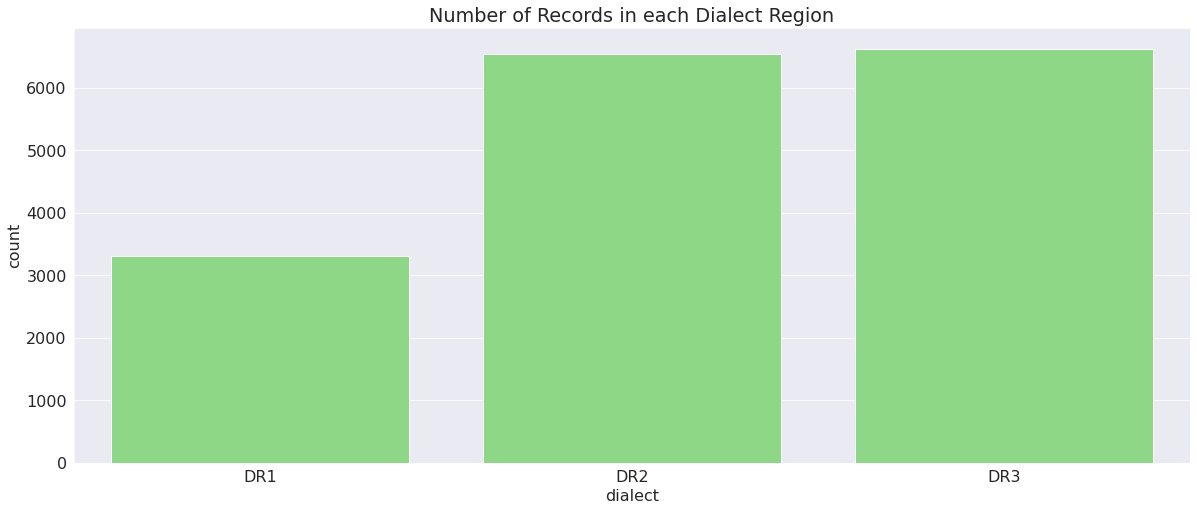

In [46]:
sns.countplot(data=data,x='dialect',color='#82E578')
plt.title("Number of Records in each Dialect Region")
plt.show()

In [5]:
data['speaker_name'] = data['speaker'].apply(lambda x: x.split('/')[1])
data['audio_name'] = data['speaker'].apply(lambda x: x.split('/')[2])

In [6]:
data

,start,end,word,dialect,speaker,phoneme,speaker_name,audio_name
0,2280,3720,he,DR1,/MRWS0/SI472,hh iy,MRWS0,SI472
1,3720,8840,played,DR1,/MRWS0/SI472,pcl p l ey dcl,MRWS0,SI472
2,8840,17640,basketball,DR1,/MRWS0/SI472,b ae s kcl k ix bcl ao l,MRWS0,SI472
3,17640,21400,there,DR1,/MRWS0/SI472,dh eh r,MRWS0,SI472
4,21400,24600,while,DR1,/MRWS0/SI472,w ay l,MRWS0,SI472
...,...,...,...,...,...,...,...,...
16477,16083,22266,silky,DR3,/FEME0/SI1505,s ih l kcl k iy,FEME0,SI1505
16478,22266,27240,hair,DR3,/FEME0/SI1505,hv eh axr,FEME0,SI1505
16479,29075,30830,and,DR3,/FEME0/SI1505,q ix n,FEME0,SI1505
16480,30830,37280,hard,DR3,/FEME0/SI1505,hh aa r dcl,FEME0,SI1505


In [7]:
train_labels = set(data[data['dialect'].isin(['DR1','DR2'])]['word'].tolist())
val_labels = set(data[data['dialect']=='DR3']['word'].tolist())

## Number of Words Common between Training set DR and Validation set DR

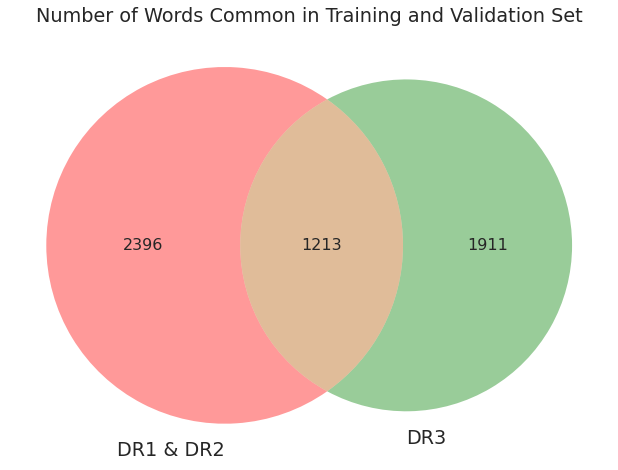

In [47]:
venn2(subsets = (len(train_labels), len(val_labels), len(train_labels & val_labels)), set_labels = ('DR1 & DR2', 'DR3'))
plt.title("Number of Words Common in Training and Validation Set")
plt.show()

# Data Preprocessing
- Since we need to train our model to classify phonemes into their respective words, the data has to be preprocessed accordingly
1. Encoding Target Words - Output
2. Tokenization of Phonemes - Input
3. Padded Sequences of Phonemes - Input
4. Embedded Representation of Phonemes

Once the input and output are in desired formats, a sequence model like RNN-LSTM can be used to classify the sequence of phonemes into their respective words.

<img src='https://www.mdpi.com/photonics/photonics-08-00535/article_deploy/html/images/photonics-08-00535-g001.png'>

## Word Label Encoding

In [11]:
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['word'])

In [12]:
train = data[data['dialect'].isin(['DR1','DR2'])][['phoneme','word','label']]
train = train.sample(frac=1).reset_index(drop=True)
val = data[data['dialect']=='DR3'].reset_index(drop=True)[['phoneme','word','label']]

## Phoneme Tokenization and Padding 

In [15]:
phonemes = data['phoneme'].tolist()
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(phonemes)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)
print(tokenizer.word_index)

Vocab Size:  62
{'OOV': 1, 'ix': 2, 's': 3, 'n': 4, 'iy': 5, 'tcl': 6, 'r': 7, 'l': 8, 'kcl': 9, 'dcl': 10, 'ih': 11, 'k': 12, 't': 13, 'ae': 14, 'ax': 15, 'm': 16, 'eh': 17, 'z': 18, 'd': 19, 'axr': 20, 'w': 21, 'aa': 22, 'dh': 23, 'ao': 24, 'dx': 25, 'pcl': 26, 'p': 27, 'q': 28, 'ay': 29, 'ah': 30, 'gcl': 31, 'ey': 32, 'f': 33, 'sh': 34, 'er': 35, 'ow': 36, 'b': 37, 'g': 38, 'v': 39, 'ux': 40, 'bcl': 41, 'y': 42, 'jh': 43, 'ng': 44, 'hv': 45, 'nx': 46, 'hh': 47, 'el': 48, 'ch': 49, 'oy': 50, 'aw': 51, 'en': 52, 'th': 53, 'uw': 54, 'uh': 55, 'h': 56, 'epi': 57, 'zh': 58, 'em': 59, 'eng': 60, 'pau': 61}


In [16]:
sequences = train['phoneme'].values

In [17]:
train_sequences = tokenizer.texts_to_sequences(train['phoneme'].values)
val_sequences = tokenizer.texts_to_sequences(val['phoneme'].values)
max_length = len(max(sequences, key=len))
print(max_length)

46


In [18]:
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_val = pad_sequences(val_sequences, maxlen=max_length, padding='post')
y_train = train['label'].values
y_val = val['label'].values

# Modelling
- Lets use a Bidirectional LSTM to classify the phonemes into its respective words

<div class='alert alert-info'><strong>Note: </strong>Here our objective is not to create a strong classification model. Since the words across the different Dialect Regions are not common, we will let the model overfit on the training data and then predict the target word in our validation set. Followed by this we will calculate the distance between the actual word and predicted word. Here, the idea is to capture the essence of how similar phonemes can lead to the prediction of almost similar kind of words.</div>

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [20]:
embedding_dim = 10
n_words = data['label'].nunique()

model = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length),
                    Bidirectional(LSTM(50)),
                    Dense(8, activation='relu'),
                    Dense(n_words, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

2022-09-16 11:47:44.233917: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46, 10)            620       
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               24400     
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
_________________________________________________________________
dense_1 (Dense)              (None, 3094)              27846     
Total params: 53,674
Trainable params: 53,674
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val,y_val),
                    validation_batch_size=32)

Epoch 1/50


2022-09-16 11:47:44.986798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


308/308 [==============================] - 24s 67ms/step - loss: 6.8225 - val_loss: 6.3761
Epoch 2/50
308/308 [==============================] - 19s 62ms/step - loss: 6.0301 - val_loss: 6.1236
Epoch 3/50
308/308 [==============================] - 18s 60ms/step - loss: 5.7620 - val_loss: 5.9950
Epoch 4/50
308/308 [==============================] - 19s 61ms/step - loss: 5.5170 - val_loss: 5.9048
Epoch 5/50
308/308 [==============================] - 19s 61ms/step - loss: 5.2390 - val_loss: 5.7627
Epoch 6/50
308/308 [==============================] - 19s 61ms/step - loss: 5.0221 - val_loss: 5.6804
Epoch 7/50
308/308 [==============================] - 19s 62ms/step - loss: 4.8246 - val_loss: 5.5828
Epoch 8/50
308/308 [==============================] - 19s 60ms/step - loss: 4.6300 - val_loss: 5.5352
Epoch 9/50
308/308 [==============================] - 19s 62ms/step - loss: 4.4581 - val_loss: 5.5328
Epoch 10/50
308/308 [==============================] - 19s 61ms/step - loss: 4.3091 - val_los

<div class='alert alert-warning'><strong>Evaluation Note: </strong>Poor results in the evaluation are to be expected due to the reasons mentioned earlier. Evaluation will be done on the basis of word distances.</div>

In [24]:
model.evaluate(X_val,y_val)

208/208 [==============================] - 3s 14ms/step - loss: 9.4439


9.443924903869629

# Inference
- We will first form the sentences using the phonemes and then try to predict the word sentences by classifying each phoneme present in the sentence
- Then we will calculate the distances between actual and predicted word by representing each word as a vector using embedding representation

In [25]:
records = []
for speaker in tqdm(data['speaker'].unique()):
    sentence = " ".join(data[data['speaker']==speaker]['word'].tolist())
    phoneme = "  ".join(data[data['speaker']==speaker]['phoneme'].tolist())
    records.append([speaker,sentence,phoneme])

100%|██████████| 1900/1900 [00:06<00:00, 289.98it/s]


In [26]:
df = pd.DataFrame(records,columns=['speaker','sentence','phonemes'])
df.head()

,speaker,sentence,phonemes
0,/MRWS0/SI472,he played basketball there while working towar...,hh iy pcl p l ey dcl b ae s kcl k ix bcl ao ...
1,/MRWS0/SA1,she had your dark suit in greasy wash water al...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...
2,/MRWS0/SI1102,the beatniks crave a sexual experience in whic...,dh ix bcl b iy q n ih kcl k s kcl k r ey v ...
3,/MRWS0/SX202,how much allowance do you get,hh ah m ah tcl ch ax l aw ax n s dcl d ux ...
4,/MRWS0/SI1732,bitter unreasoning jealousy,bcl b ih dx er ah n r iy z n iy ng dcl jh eh...


## Predict each Word in Sentence
- Since the phoneme sentences are separated by double blank spaces, we can tokenize the phoneme sequences and pass them to our model to predict the target word
- This entire process is repeated for all the phoneme sequences in the sentence to produce the target word

In [27]:
def predict_words(sentence):
    phonemes = sentence.split("  ")
    word_sentence = ""
    for x in phonemes:
        text_seq = tokenizer.texts_to_sequences([x])
        text_padded = pad_sequences(text_seq, maxlen=max_length, padding='post')
        pred = model.predict(text_padded)
        pred = np.argmax(pred,axis=1)
        word = encoder.classes_[pred[0]]
        word_sentence = word_sentence + word + " "
    word_sentence = word_sentence.strip()
    return word_sentence

In [28]:
df['sentence_predictions'] = df['phonemes'].progress_apply(predict_words)

100%|██████████| 1900/1900 [16:11<00:00,  1.95it/s]


In [30]:
df = pd.merge(df,data[['speaker','dialect']].drop_duplicates(),how='left',left_on='speaker',right_on='speaker')
df

,speaker,sentence,phonemes,sentence_predictions,dialect
0,/MRWS0/SI472,he played basketball there while working towar...,hh iy pcl p l ey dcl b ae s kcl k ix bcl ao ...,he play emotions that wide needle come a law dark,DR1
1,/MRWS0/SA1,she had your dark suit in greasy wash water al...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...,she had your dark suit in greasy wash water al...,DR1
2,/MRWS0/SI1102,the beatniks crave a sexual experience in whic...,dh ix bcl b iy q n ih kcl k s kcl k r ey v ...,the sometimes john's a nothing experience in t...,DR1
3,/MRWS0/SX202,how much allowance do you get,hh ah m ah tcl ch ax l aw ax n s dcl d ux ...,her much allowance do you get,DR1
4,/MRWS0/SI1732,bitter unreasoning jealousy,bcl b ih dx er ah n r iy z n iy ng dcl jh eh...,subject unreasoning turquoise,DR1
...,...,...,...,...,...
1895,/FEME0/SX155,the water contained too much chlorine and stun...,dh ax w ao dx axr kcl k ix n tcl t ey n dcl ...,the water activities to much girls ask him his...,DR3
1896,/FEME0/SA2,don't ask me to carry an oily rag like that,d ow n tcl q ae s kcl k m ix dx ix kcl k i...,don't ask me to carry in oily rag like that,DR3
1897,/FEME0/SX65,challenge each general's intelligence,ch ae l ax n dcl jh q iy tcl ch dcl jh eh nx...,thinks each general's cartoons,DR3
1898,/FEME0/SI875,look for these features which may mean you can...,l uh kcl k f ix dh iy z f iy tcl ch axr z ...,like for these features tell may many you can ...,DR3


## Word-Vector Representations
- Now that we have the predicted word sentences, we can calculate the difference between the actual and predicted words
- But first we need to convert the words into some form of vector representation
- Lets use the pretrained embeddings layer for this (other embeddings like word2vec, glove, etc. can also be used)

Once we are in this vector space we can calculate the difference between the actual and predicted words in the sentences
<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/06062705/Word-Vectors.png'>

In [32]:
sentences = df['sentence'].tolist() + df['sentence_predictions'].tolist()
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  3096


In [33]:
from scipy.spatial.distance import euclidean

## Distance Calculation
- For calculating the distances, we will use the L2-Distance aka Euclidean Distance

<img src='https://miro.medium.com/max/1400/1*L1pWK9foGvUIT7uQM9f_yQ.png'>

<div class='alert alert-info'><strong>Note: </strong>Two distances will be calculated, one for each word in a sentences and the other will be a cumulative distance of all the word distances</div>

In [34]:
def word_distances(w1,w2):
    x1 = np.array(tokenizer.texts_to_sequences([w1])[0])
    x2 = np.array(tokenizer.texts_to_sequences([w2])[0])
    word_vector = Embedding(vocab_size, 16, input_length=1)
    v1 = word_vector(x1)
    v2 = word_vector(x2)
    distance = euclidean(v1,v2)
    return round(distance,2)

def sentences_dist_total(sent1,sent2):
    total_dist = 0
    for word1,word2 in zip(sent1.split(),sent2.split()):
        total_dist+=word_distances(word1,word2)
    return total_dist

def sentences_dist(sent1,sent2):
    dist = ""
    for word1,word2 in zip(sent1.split(),sent2.split()):
        dist+=str(word_distances(word1,word2))+','
    dist = dist.strip(",")
    return dist

In [35]:
df['word_distances'] = df.progress_apply(lambda x: sentences_dist(x['sentence'],x['sentence_predictions']),axis=1)
df['word_distances_total'] = df.progress_apply(lambda x: sentences_dist_total(x['sentence'],x['sentence_predictions']),axis=1)

100%|██████████| 1900/1900 [00:49<00:00, 38.58it/s]


In [36]:
df

,speaker,sentence,phonemes,sentence_predictions,dialect,word_distances,word_distances_total
0,/MRWS0/SI472,he played basketball there while working towar...,hh iy pcl p l ey dcl b ae s kcl k ix bcl ao ...,he play emotions that wide needle come a law dark,DR1,"0.0,0.15,0.18,0.15,0.18,0.13,0.12,0.0,0.0,0.14",1.07
1,/MRWS0/SA1,she had your dark suit in greasy wash water al...,sh iy hv ae dcl d y axr dcl d aa r kcl k s...,she had your dark suit in greasy wash water al...,DR1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",0.00
2,/MRWS0/SI1102,the beatniks crave a sexual experience in whic...,dh ix bcl b iy q n ih kcl k s kcl k r ey v ...,the sometimes john's a nothing experience in t...,DR1,"0.0,0.19,0.15,0.0,0.14,0.0,0.0,0.14,0.15,0.14,...",1.08
3,/MRWS0/SX202,how much allowance do you get,hh ah m ah tcl ch ax l aw ax n s dcl d ux ...,her much allowance do you get,DR1,"0.1,0.0,0.0,0.0,0.0,0.0",0.20
4,/MRWS0/SI1732,bitter unreasoning jealousy,bcl b ih dx er ah n r iy z n iy ng dcl jh eh...,subject unreasoning turquoise,DR1,"0.18,0.0,0.21",0.34
...,...,...,...,...,...,...,...
1895,/FEME0/SX155,the water contained too much chlorine and stun...,dh ax w ao dx axr kcl k ix n tcl t ey n dcl ...,the water activities to much girls ask him his...,DR3,"0.0,0.0,0.16,0.12,0.0,0.16,0.19,0.22,0.0,0.0",0.83
1896,/FEME0/SA2,don't ask me to carry an oily rag like that,d ow n tcl q ae s kcl k m ix dx ix kcl k i...,don't ask me to carry in oily rag like that,DR3,"0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0",0.15
1897,/FEME0/SX65,challenge each general's intelligence,ch ae l ax n dcl jh q iy tcl ch dcl jh eh nx...,thinks each general's cartoons,DR3,"0.17,0.0,0.0,0.2",0.34
1898,/FEME0/SI875,look for these features which may mean you can...,l uh kcl k f ix dh iy z f iy tcl ch axr z ...,like for these features tell may many you can ...,DR3,"0.17,0.0,0.0,0.0,0.16,0.0,0.2,0.0,0.0,0.13,0.1...",1.07


## Distribution of Distances of Word Sentences
- It seems as if the more commonly occuring words are getting predicted well due to which the distances between them is as low as 0
- While there are other cases as well i.e. the words that are not just as common 

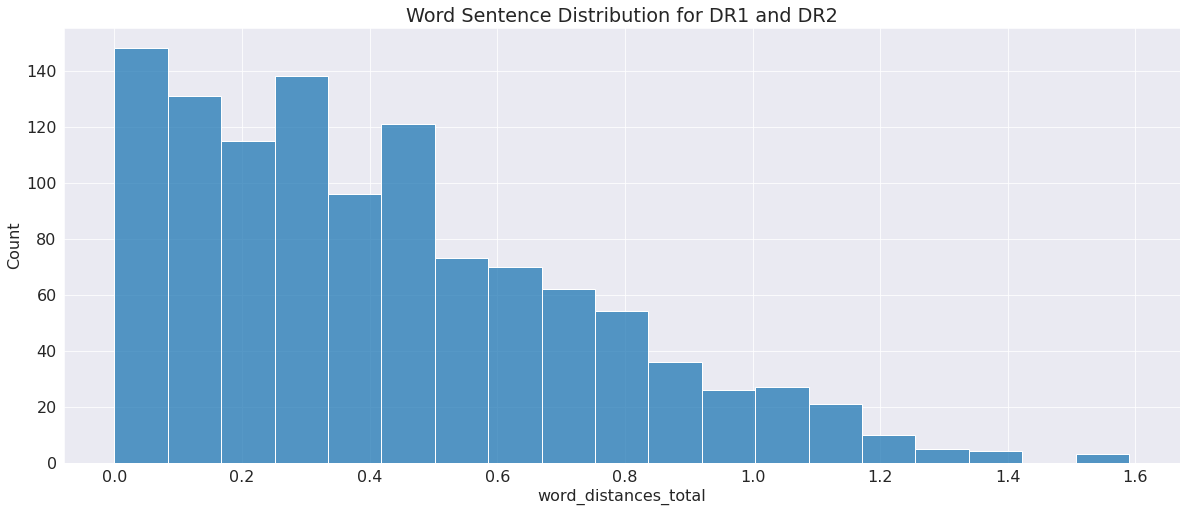

In [49]:
sns.histplot(df[df['dialect'].isin(['DR1','DR2'])]['word_distances_total'])
plt.title("Word Sentence Distribution for DR1 and DR2")
plt.show()

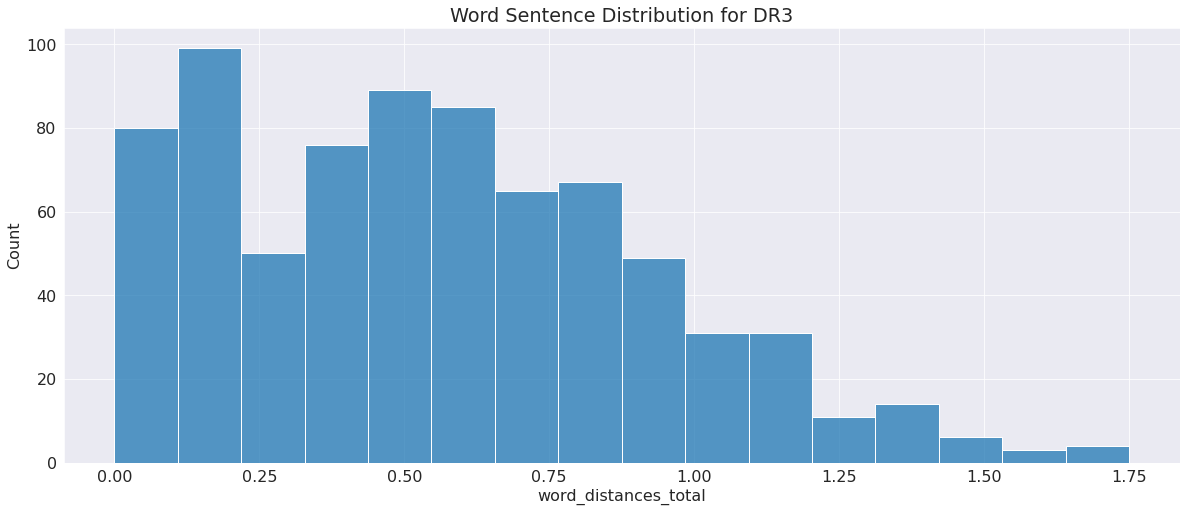

In [50]:
sns.histplot(df[df['dialect'].isin(['DR3'])]['word_distances_total'])
plt.title("Word Sentence Distribution for DR3")
plt.show()

## Examples: DR1 and DR2 

In [59]:
for i in range(5):
    print(f"Actual: ",df.iloc[i].sentence,"\nPredicted: ",df.iloc[i].sentence_predictions,"\nWord Dist: ",df.iloc[i].word_distances)
    print("\n")

Actual:  he played basketball there while working toward a law degree 
Predicted:  he play emotions that wide needle come a law dark 
Word Dist:  0.0,0.15,0.18,0.15,0.18,0.13,0.12,0.0,0.0,0.14


Actual:  she had your dark suit in greasy wash water all year 
Predicted:  she had your dark suit in greasy wash water all year 
Word Dist:  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Actual:  the beatniks crave a sexual experience in which their whole being participates 
Predicted:  the sometimes john's a nothing experience in tell that only being participate 
Word Dist:  0.0,0.19,0.15,0.0,0.14,0.0,0.0,0.14,0.15,0.14,0.0,0.19


Actual:  how much allowance do you get 
Predicted:  her much allowance do you get 
Word Dist:  0.1,0.0,0.0,0.0,0.0,0.0


Actual:  bitter unreasoning jealousy 
Predicted:  subject unreasoning turquoise 
Word Dist:  0.18,0.0,0.21




## Examples: DR3

In [61]:
for i in range(5):
    print(f"Actual: ",df[df['dialect']=='DR3'].iloc[i].sentence,"\nPredicted: ",df[df['dialect']=='DR3'].iloc[i].sentence_predictions,"\nWord Dist: ",df[df['dialect']=='DR3'].iloc[i].word_distances)
    print("\n")

Actual:  do you always navigate like this 
Predicted:  do you gowns maladies like this 
Word Dist:  0.0,0.0,0.16,0.15,0.0,0.0


Actual:  the advertising verse of plymouth variety store never changes 
Predicted:  the confronted verse of patient survey star never vanquished 
Word Dist:  0.0,0.15,0.0,0.0,0.18,0.16,0.22,0.0,0.15


Actual:  she had your dark suit in greasy wash water all year 
Predicted:  she had your dark suit in greasy wash water all year 
Word Dist:  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Actual:  many wealthy tycoons splurged and bought both a yacht and a schooner 
Predicted:  many wealth gigantic process and bought both a your and a thoroughly 
Word Dist:  0.0,0.15,0.15,0.16,0.0,0.0,0.0,0.0,0.12,0.0,0.0,0.14


Actual:  remember to allow identical twins to enter freely 
Predicted:  reflects to coffee mosquitoes reminded to enter freely 
Word Dist:  0.15,0.0,0.14,0.15,0.14,0.0,0.0,0.0




<div class='alert alert-success'><strong>Conclusion:</strong>
    <li>The approach carried out in this notebook should give a gist of how challenging it can be to predict a word given the phoneme or pronunciation of a word from different dialect regions.</li>
    <li>Since only 3 DRs were considered, we can consider more number of DRs to capture the patterns of less frequently occuring words and their respective phonemes</li>
    <li>A more concrete approach would be to use a seq2seq model where an encoder would be used to create a context vector capturing the patterns of the phonemes from different DRs and a decoder would be used to classify and generate the respective english word of each phoneme</li>
</div>